# Best Practices for Reporting and Communicating Marginal Effects

**Series:** Marginal Effects Tutorial Series — Notebook 6 of 6  
**Level:** Intermediate (focus on communication, not computation)  
**Estimated Duration:** 60 minutes  
**Prerequisites:** Notebooks 01–05 (all prior series notebooks)  
**Dataset:** Mroz (1987) — Women's Labor Force Participation

---

## Introduction

In Notebooks 01–05 you learned *how* to compute marginal effects for every major
nonlinear model class: binary discrete models (Logit/Probit), count models
(Poisson/NegBin), censored models (Tobit/Heckman), ordered models, and models
with interactions. Getting the numbers right is only **half the job**.

This final notebook focuses on what happens **after** the computation:
how to present your results clearly, accurately, and professionally.

---

## What This Notebook Covers

| Section | Topic |
|---------|-------|
| 1 | Standard table formats used in published research |
| 2 | LaTeX and HTML export |
| 3 | Plain-language interpretation templates |
| 4 | Publication-ready visualizations (5 types) |
| 5 | Audience-specific communication (4 versions) |
| 6 | Six common errors to avoid |
| 7 | Final checklist before submission |

The **Mroz Logit example** from Notebook 01 serves as the running example
throughout. All results are re-computed from scratch — this notebook is
fully self-contained.

---

## Learning Objectives

By the end of this notebook you will be able to:

1. Structure a professional marginal effects table for academic publication
2. Choose the right level of detail for different audiences
3. Write plain-language sentences interpreting ME results
4. Create publication-ready visualizations (forest plots, coefficient plots)
5. Export tables to LaTeX and HTML formats
6. Identify and avoid the six most common ME reporting errors
7. Apply a structured checklist before submitting any paper or report

In [1]:
# Cell 2 — Setup: imports and publication-quality matplotlib settings
import sys
import os

# Make PanelBox importable from any working directory
sys.path.insert(0, '/home/guhaase/projetos/panelbox')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.patches import Patch

import panelbox as pb
from panelbox.models.discrete.binary import PooledLogit, PooledProbit
from panelbox.marginal_effects.discrete_me import compute_ame, compute_mem

# Add the series utils directory to the path
_utils_dir = '/home/guhaase/projetos/panelbox/examples/marginal_effects/utils'
if _utils_dir not in sys.path:
    sys.path.insert(0, _utils_dir)

from data_loaders import load_dataset
from me_helpers import plot_forest, format_me_table

# --- Matplotlib settings for publication quality ---
# Clean, print-ready style: no gray background, crisp fonts
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except OSError:
    plt.style.use('seaborn-whitegrid')

plt.rcParams.update({
    'font.size': 11,
    'axes.titlesize': 12,
    'axes.labelsize': 11,
    'figure.dpi': 150,
    'savefig.bbox': 'tight',
    'savefig.dpi': 150,
})

pd.set_option('display.float_format', '{:.4f}'.format)

# Output directories (same as the rest of the series)
_PLOTS_DIR  = '/home/guhaase/projetos/panelbox/examples/marginal_effects/outputs/plots'
_TABLES_DIR = '/home/guhaase/projetos/panelbox/examples/marginal_effects/outputs/tables'
os.makedirs(_PLOTS_DIR,  exist_ok=True)
os.makedirs(_TABLES_DIR, exist_ok=True)

print('Setup complete.')
print(f'PanelBox version: {pb.__version__ if hasattr(pb, "__version__") else "(unknown)"}')
print(f'Output plots  -> {_PLOTS_DIR}')
print(f'Output tables -> {_TABLES_DIR}')

Setup complete.
PanelBox version: 1.0.0
Output plots  -> /home/guhaase/projetos/panelbox/examples/marginal_effects/outputs/plots
Output tables -> /home/guhaase/projetos/panelbox/examples/marginal_effects/outputs/tables


In [2]:
# Cell 3 — Re-estimate baseline models from scratch
# This makes the notebook fully self-contained (no dependency on earlier notebooks).

# Load the Mroz (1987) dataset
# Real columns: inlf, hours, age, educ, exper, expersq, nwifeinc, kidslt6, kidsge6, wage
df = load_dataset('mroz')
print(f"Dataset loaded: {df.shape[0]} observations, {df.shape[1]} columns")
print(f"Columns: {list(df.columns)}")

# Cross-section treated as single-period panel (standard setup)
df = df.copy()
df['id']   = range(len(df))
df['time'] = 1

# Formula using real column names (inlf is the outcome; kidslt6, kidsge6 — NOT lfp/kids_lt6)
# Real PooledLogit API: PooledLogit(formula, data=DataFrame, entity_col, time_col)
formula = 'inlf ~ educ + age + kidslt6 + kidsge6 + nwifeinc'

# Estimate Pooled Logit
logit  = PooledLogit(formula=formula,  data=df, entity_col='id', time_col='time').fit()

# Estimate Pooled Probit (for robustness comparison in Cell 15)
probit = PooledProbit(formula=formula, data=df, entity_col='id', time_col='time').fit()

# Compute Average Marginal Effects (AME) and Marginal Effects at Means (MEM)
ame_logit  = compute_ame(logit)
ame_probit = compute_ame(probit)
mem_logit  = compute_mem(logit)

# Pseudo R-squared (McFadden): try attribute first, compute from llf/llnull as fallback
try:
    prsq_logit = logit.prsquared
except Exception:
    try:
        prsq_logit = 1 - logit.llf / logit.llnull
    except Exception:
        prsq_logit = float('nan')

# N observations
try:
    n_obs = logit.nobs
except Exception:
    try:
        n_obs = logit.nobs_total
    except Exception:
        n_obs = len(df)

print(f"\nModels estimated successfully.")
print(f"N = {n_obs}  |  Pseudo R\u00b2 (Logit, McFadden) = {prsq_logit:.4f}")
print(f"\nLogit AME:")
print(pd.DataFrame({'AME': ame_logit.marginal_effects, 'SE': ame_logit.std_errors}).round(4))

Dataset loaded: 753 observations, 10 columns
Columns: ['inlf', 'hours', 'age', 'educ', 'exper', 'expersq', 'nwifeinc', 'kidslt6', 'kidsge6', 'wage']



Models estimated successfully.
N = 753  |  Pseudo R² (Logit, McFadden) = nan

Logit AME:
              AME     SE
Intercept -0.1768 0.1583
educ       0.0056 0.0033
age        0.0002 0.0012
kidslt6   -0.0631 0.0116
kidsge6   -0.0029 0.0090
nwifeinc  -0.0028 0.0009


## Section 1: Standard Table Formats

Academic tables for marginal effects follow specific conventions that vary
across journals but converge on a common core.
The two most commonly used formats:

---

### Format A — ME-only table

Used when coefficients appear in a supplementary appendix or are secondary:

| Variable | AME | SE | Sig. |
|----------|-----|----|------|
| educ | 0.0381 | (0.0087) | *** |
| age | −0.0162 | (0.0024) | *** |
| ... | ... | ... | ... |

### Format B — Side-by-side (coefficients + AME)

Used when the paper discusses both the sign/significance of coefficients
and the economic magnitude via AME:

| Variable | Coeff. | (SE) | AME | (SE) |
|----------|--------|------|-----|------|
| educ | 0.8231 | (0.1763) | 0.0381 | (0.0087) |
| ... | ... | ... | ... | ... |

---

**Both formats must include:**
- Number of observations (N)
- Pseudo R² or log-likelihood
- Specification of ME type (AME/MEM) and inference method (delta method/bootstrap)
- Standard error type note (robust? clustered?)
- Significance legend

**Never omit standard errors.** A table with only AME values (no SE) is incomplete.

In [3]:
# Cell 5 — Format A: ME-only table
# A clean, ready-to-publish table with AME, SE, and significance stars.

def build_me_table_format_a(me_result, title='AME Table', stars=True, note=''):
    """
    Build a publication-ready ME-only table (Format A).

    Parameters
    ----------
    me_result : MarginalEffectsResult
        Computed marginal effects (from compute_ame / compute_mem).
    title : str
        Table heading to print.
    stars : bool
        If True, append significance stars to the AME value.
    note : str
        Footnote appended below the table.

    Returns
    -------
    pd.DataFrame
        Structured table with columns: Variable, AME, SE, p-value.
    """
    me   = me_result.marginal_effects
    se   = me_result.std_errors
    pval = me_result.pvalues

    def sig_stars(p):
        """Return significance stars for a p-value."""
        if p < 0.001: return '***'
        if p < 0.01:  return '**'
        if p < 0.05:  return '*'
        if p < 0.10:  return '.'
        return ''

    rows = {}
    for var in me.index:
        m = float(me[var])
        s = float(se[var])
        p = float(pval[var])
        star = sig_stars(p) if stars else ''
        rows[var] = {
            'AME':     f'{m:+.4f}{star}',
            'SE':      f'({s:.4f})',
            'p-value': f'{p:.4f}',
        }

    table = pd.DataFrame(rows).T

    # Print formatted table
    print(f"\n{'=' * 48}")
    print(f"  {title}")
    print(f"{'=' * 48}")
    print(f"{'Variable':<15} {'AME':>12} {'SE':>12} {'p-value':>10}")
    print(f"{'-' * 48}")
    for var in table.index:
        print(f"{var:<15} {table.loc[var, 'AME']:>12} "
              f"{table.loc[var, 'SE']:>12} {table.loc[var, 'p-value']:>10}")
    print(f"{'-' * 48}")
    if note:
        print(f"Note: {note}")

    return table


print("=== Format A: AME-only Table — Pooled Logit ===")
tbl_a = build_me_table_format_a(
    ame_logit,
    title="Average Marginal Effects — Women's LFP",
    note="AME via delta method. *** p<.001  ** p<.01  * p<.05  . p<.10"
)

=== Format A: AME-only Table — Pooled Logit ===

  Average Marginal Effects — Women's LFP
Variable                 AME           SE    p-value
------------------------------------------------
Intercept            -0.1768     (0.1583)     0.2641
educ                +0.0056.     (0.0033)     0.0874
age                  +0.0002     (0.0012)     0.8777
kidslt6           -0.0631***     (0.0116)     0.0000
kidsge6              -0.0029     (0.0090)     0.7466
nwifeinc           -0.0028**     (0.0009)     0.0010
------------------------------------------------
Note: AME via delta method. *** p<.001  ** p<.01  * p<.05  . p<.10


In [4]:
# Cell 6 — Format B: Coefficients + AME side by side
# Combines the logit coefficient (and its SE) with the AME (and its SE).

def build_me_table_format_b(result, me_result, title='Coeff. + AME Table'):
    """
    Build a side-by-side table of logit coefficients and AME (Format B).

    Parameters
    ----------
    result : model result
        Fitted model (e.g., PooledLogit result) with .params and .std_errors.
    me_result : MarginalEffectsResult
        Computed marginal effects.
    title : str
        Table heading.

    Returns
    -------
    pd.DataFrame
        Structured table with Coeff., Coeff. SE, AME, AME SE.
    """
    coef    = result.params
    coef_se = result.std_errors
    me      = me_result.marginal_effects
    me_se   = me_result.std_errors
    pval    = me_result.pvalues

    def sig_stars(p):
        if p < 0.001: return '***'
        if p < 0.01:  return '**'
        if p < 0.05:  return '*'
        return ''

    rows = {}
    for var in coef.index:
        # Skip the intercept — it has no meaningful AME
        if var in ('const', 'Intercept', 'intercept'):
            continue
        p = float(pval.get(var, 1.0))
        c = float(coef[var])
        cs = float(coef_se[var])
        rows[var] = {
            'Coeff.':   f"{c:+.4f}{sig_stars(p)}",
            'Coeff.SE': f"({cs:.4f})",
            'AME':      f"{float(me[var]):+.4f}{sig_stars(p)}" if var in me.index else '---',
            'AME SE':   f"({float(me_se[var]):.4f})"           if var in me_se.index else '---',
        }

    table = pd.DataFrame(rows).T

    # N with fallback
    try:
        n_display = result.nobs
    except Exception:
        try:
            n_display = result.nobs_total
        except Exception:
            n_display = '?'

    # Print formatted table
    print(f"\n{'=' * 67}")
    print(f"  {title}")
    print(f"{'=' * 67}")
    print(f"{'Variable':<15} {'Coeff.':>12} {'':>12} {'AME':>10} {'':>12}")
    print(f"{'-' * 67}")
    for var in table.index:
        print(f"{var:<15} {table.loc[var, 'Coeff.']:>12} "
              f"{table.loc[var, 'Coeff.SE']:>12} "
              f"{table.loc[var, 'AME']:>10} "
              f"{table.loc[var, 'AME SE']:>12}")
    print(f"{'-' * 67}")
    print(f"N = {n_display}")
    print("*** p<.001  ** p<.01  * p<.05")

    return table


print("=== Format B: Coefficients + AME Table ===")
tbl_b = build_me_table_format_b(
    logit,
    ame_logit,
    title="Pooled Logit: Coefficients and AME — Women's LFP (Mroz 1987)"
)

=== Format B: Coefficients + AME Table ===

  Pooled Logit: Coefficients and AME — Women's LFP (Mroz 1987)
Variable              Coeff.                     AME             
-------------------------------------------------------------------
educ                 +0.0782     (0.0456)    +0.0056     (0.0033)
age                  +0.0026     (0.0166)    +0.0002     (0.0012)
kidslt6           -0.8735***     (0.1622) -0.0631***     (0.0116)
kidsge6              -0.0403     (0.1247)    -0.0029     (0.0090)
nwifeinc           -0.0390**     (0.0120)  -0.0028**     (0.0009)
-------------------------------------------------------------------
N = 753
*** p<.001  ** p<.01  * p<.05


## Section 2: LaTeX and HTML Export

After computing marginal effects, results typically need to be exported
to one of two formats:

- **LaTeX** (`.tex` file or inline snippet): for journal submissions,
  working papers, and any document written in LaTeX/Overleaf.
- **HTML**: for reports, dashboards, presentations, and web-based
  communication.

---

### Recommended export workflow

1. Build a clean `pd.DataFrame` with only the columns you need
   (AME, SE, CI bounds, p-value, significance).
2. For LaTeX: use `df.to_latex(caption=..., label=..., escape=False)`.
3. For HTML: use `df.style.format(...).set_caption(...).to_html()`.
4. Always save to a file and keep it alongside the notebook.

---

### Key pitfalls

- **Do not** copy raw pandas `print()` output into a paper — formatting
  is wrong and alignment breaks in LaTeX.
- **Do not** include too many decimal places; 3–4 significant figures
  for ME and SE is standard.
- **Do not** export the full covariance matrix or diagnostic statistics
  that belong in an appendix.

In [5]:
# Cell 8 — LaTeX export
# Build a clean DataFrame and export to a .tex file.

def me_to_export_df(me_result, model_name=''):
    """
    Build a clean DataFrame suitable for LaTeX/HTML export.

    Columns: AME, SE, CI Lower, CI Upper, p-value, Sig.

    Parameters
    ----------
    me_result : MarginalEffectsResult
        Computed marginal effects.
    model_name : str
        Optional model label (printed as note).

    Returns
    -------
    pd.DataFrame
    """
    me   = me_result.marginal_effects
    se   = me_result.std_errors
    pval = me_result.pvalues
    ci   = me_result.conf_int(alpha=0.05)   # Returns DataFrame with 'lower' / 'upper'

    def stars(p):
        if p < 0.001: return '***'
        if p < 0.01:  return '**'
        if p < 0.05:  return '*'
        return ''

    df_out = pd.DataFrame({
        'AME':      me.round(4),
        'SE':       se.round(4),
        'CI Lower': ci.iloc[:, 0].round(4),   # first column = lower
        'CI Upper': ci.iloc[:, 1].round(4),   # second column = upper
        'p-value':  pval.round(4),
        'Sig.':     [stars(float(p)) for p in pval],
    })

    if model_name:
        print(f"Export DataFrame for model: {model_name}")

    return df_out


# Build the export DataFrame
export_df = me_to_export_df(ame_logit, model_name='Pooled Logit')

# Generate LaTeX string
latex_str = export_df.to_latex(
    float_format='%.4f',
    caption="Average Marginal Effects --- Women's Labor Force Participation (Mroz 1987)",
    label='tab:ame_lfp',
    escape=False,
)

print("=== LaTeX Output ===")
print(latex_str)

# Save to file
_latex_path = os.path.join(_TABLES_DIR, '06_ame_logit.tex')
with open(_latex_path, 'w') as f:
    f.write(latex_str)

print(f"Saved LaTeX table to: {_latex_path}")

Export DataFrame for model: Pooled Logit
=== LaTeX Output ===
\begin{table}
\caption{Average Marginal Effects --- Women's Labor Force Participation (Mroz 1987)}
\label{tab:ame_lfp}
\begin{tabular}{lrrrrrl}
\toprule
 & AME & SE & CI Lower & CI Upper & p-value & Sig. \\
\midrule
Intercept & -0.1768 & 0.1583 & -0.4872 & 0.1335 & 0.2641 &  \\
educ & 0.0056 & 0.0033 & -0.0008 & 0.0121 & 0.0874 &  \\
age & 0.0002 & 0.0012 & -0.0022 & 0.0025 & 0.8777 &  \\
kidslt6 & -0.0631 & 0.0116 & -0.0858 & -0.0404 & 0.0000 & *** \\
kidsge6 & -0.0029 & 0.0090 & -0.0206 & 0.0148 & 0.7466 &  \\
nwifeinc & -0.0028 & 0.0009 & -0.0045 & -0.0011 & 0.0010 & ** \\
\bottomrule
\end{tabular}
\end{table}

Saved LaTeX table to: /home/guhaase/projetos/panelbox/examples/marginal_effects/outputs/tables/06_ame_logit.tex


In [6]:
# Cell 9 — HTML export with styling
# A styled HTML table suitable for reports or web dashboards.

# Build styled HTML
html_str = (
    export_df.style
    .format({
        'AME':      '{:.4f}',
        'SE':       '{:.4f}',
        'CI Lower': '{:.4f}',
        'CI Upper': '{:.4f}',
        'p-value':  '{:.4f}',
    })
    .set_caption("Average Marginal Effects --- Women's LFP (Mroz 1987)")
    .set_table_styles([
        {'selector': 'caption',
         'props': [('font-size', '14px'), ('font-weight', 'bold'), ('padding', '8px')]},
        {'selector': 'th',
         'props': [('background-color', '#2c3e50'), ('color', 'white'), ('padding', '6px')]},
        {'selector': 'td',
         'props': [('padding', '4px 8px'), ('border-bottom', '1px solid #ddd')]},
        {'selector': 'tr:nth-child(even)',
         'props': [('background-color', '#f2f2f2')]},
    ])
    .to_html()
)

# Save to file
_html_path = os.path.join(_TABLES_DIR, '06_ame_logit.html')
with open(_html_path, 'w') as f:
    f.write(html_str)

print(f"Saved HTML table to: {_html_path}")
print("\nPreview (first 5 rows):")
print(export_df.head())

Saved HTML table to: /home/guhaase/projetos/panelbox/examples/marginal_effects/outputs/tables/06_ame_logit.html

Preview (first 5 rows):
              AME     SE  CI Lower  CI Upper  p-value Sig.
Intercept -0.1768 0.1583   -0.4872    0.1335   0.2641     
educ       0.0056 0.0033   -0.0008    0.0121   0.0874     
age        0.0002 0.0012   -0.0022    0.0025   0.8777     
kidslt6   -0.0631 0.0116   -0.0858   -0.0404   0.0000  ***
kidsge6   -0.0029 0.0090   -0.0206    0.0148   0.7466     


## Section 3: Plain-Language Interpretation

The numbers alone are not enough — a good paper also contains clear,
precise sentences that translate the statistical results into economic insight.

---

### Templates by variable type

**Continuous variable:**
> "A one-[unit] increase in [variable] is associated with a [|AME|×100] percentage
> point [increase/decrease] in the probability of [outcome]
> (AME = [value], SE = [se], [sig]; 95% CI: [[lo], [hi]])."

**Dummy variable:**
> "[Variable = 1] is associated with a [|AME|×100] percentage point
> [higher/lower] probability of [outcome] compared to [Variable = 0]
> (AME = [value], SE = [se], [sig])."

**Insignificant result:**
> "The estimated effect of [variable] on [outcome] is [value] percentage
> points, but this is not statistically significant at conventional
> levels (p = [pvalue])."

---

### Common mistakes in written interpretations

| Incorrect | Correct |
|-----------|--------|
| "The coefficient of education is 0.82" | Report the AME, not the coefficient |
| "Education increases probability by 82%" | This confuses the coefficient with a percentage |
| "Effect is significant" | Always specify the threshold (5%? 1%?) |
| Report AME without SE | Always pair ME with its standard error |
| "Higher education leads to participation" | Causation requires a different research design |

**Use "is associated with"** unless you have a credible identification
strategy (RCT, IV, RDD, etc.) that supports causal language.

In [7]:
# Cell 11 — Plain-language interpretation generator
# Produces ready-to-paste text for each variable.

def interpret_me(variable, me_result, outcome_name, unit_desc='unit'):
    """
    Generate a plain-language interpretation sentence for a variable's AME.

    Parameters
    ----------
    variable : str
        Variable name in me_result.marginal_effects.
    me_result : MarginalEffectsResult
        Computed marginal effects.
    outcome_name : str
        Human-readable name of the outcome (e.g., 'labor force participation').
    unit_desc : str
        Description of one unit of the variable (e.g., 'year', 'child under 6').
    """
    me_val = float(me_result.marginal_effects[variable])
    se_val = float(me_result.std_errors[variable])
    pval   = float(me_result.pvalues[variable])

    # Build confidence interval using 'lower'/'upper' columns (real API)
    ci = me_result.conf_int()
    ci_lo = float(ci.loc[variable, 'lower']) if 'lower' in ci.columns \
            else me_val - 1.96 * se_val
    ci_hi = float(ci.loc[variable, 'upper']) if 'upper' in ci.columns \
            else me_val + 1.96 * se_val

    direction = 'increases' if me_val > 0 else 'decreases'
    pct_change = abs(me_val) * 100

    # Map p-value to significance language
    if pval < 0.001:
        sig_str  = 'p < 0.001'
        sig_note = 'highly significant (p < 0.001)'
    elif pval < 0.01:
        sig_str  = 'p < 0.01'
        sig_note = 'significant at the 1% level'
    elif pval < 0.05:
        sig_str  = 'p < 0.05'
        sig_note = 'significant at the 5% level'
    else:
        sig_str  = f'p = {pval:.3f}'
        sig_note = 'not statistically significant at conventional levels'

    print(f"--- {variable.upper()} ---")
    print(f"An additional {unit_desc} of {variable} {direction} the probability")
    print(f"of {outcome_name} by {pct_change:.1f} percentage points")
    print(f"(AME = {me_val:+.4f}, SE = {se_val:.4f}, {sig_str};")
    print(f" 95% CI: [{ci_lo:.4f}, {ci_hi:.4f}]).")
    print(f"This effect is {sig_note}.")
    print()


print("=== Plain-Language Interpretation Examples ===\n")

# Four key variables from the Mroz specification
# Use real column names: kidslt6, kidsge6 (NOT kids_lt6, kids_618)
interpret_me('educ',     ame_logit, 'labor force participation',
             unit_desc='year of education')
interpret_me('age',      ame_logit, 'labor force participation',
             unit_desc='year of age')
interpret_me('kidslt6',  ame_logit, 'labor force participation',
             unit_desc='additional child under age 6')
interpret_me('nwifeinc', ame_logit, 'labor force participation',
             unit_desc='$1,000 of non-wife household income')

=== Plain-Language Interpretation Examples ===

--- EDUC ---
An additional year of education of educ increases the probability
of labor force participation by 0.6 percentage points
(AME = +0.0056, SE = 0.0033, p = 0.087;
 95% CI: [-0.0008, 0.0121]).
This effect is not statistically significant at conventional levels.

--- AGE ---
An additional year of age of age increases the probability
of labor force participation by 0.0 percentage points
(AME = +0.0002, SE = 0.0012, p = 0.878;
 95% CI: [-0.0022, 0.0025]).
This effect is not statistically significant at conventional levels.

--- KIDSLT6 ---
An additional additional child under age 6 of kidslt6 decreases the probability
of labor force participation by 6.3 percentage points
(AME = -0.0631, SE = 0.0116, p < 0.001;
 95% CI: [-0.0858, -0.0404]).
This effect is highly significant (p < 0.001).

--- NWIFEINC ---
An additional $1,000 of non-wife household income of nwifeinc decreases the probability
of labor force participation by 0.3 percent

## Section 4: Publication-Ready Visualizations

Visual communication of marginal effects is as important as the tables.
Five visualization types cover the vast majority of use cases:

| Type | Best for |
|------|----------|
| **1. Forest plot** | Comparing multiple variables in one model |
| **2. Predicted probability curve** | Showing the non-linear S-curve |
| **3. ME vs. X curve** | Showing how the ME itself varies with X |
| **4. Multi-model comparison** | Robustness checks (Logit vs Probit) |
| **5. Decomposition plot** | Tobit/Heckman intensive vs. extensive |

---

### General principles for publication graphics

- **Always include error bars** (95% CI or ±1 SE minimum)
- **Use consistent color coding**: blue = positive effect, red = negative
- **Label axes** in human units: "percentage points" not raw fractions
- **Add significance stars** where space permits
- **Use a clean theme**: no gray background (the default matplotlib theme
  and seaborn-whitegrid are both acceptable)
- **Save at ≥ 150 DPI** for print quality (300 DPI for camera-ready)
- **Keep titles informative**: include model name and dataset reference

Figure saved: /home/guhaase/projetos/panelbox/examples/marginal_effects/outputs/plots/06_publication_forest_plot.png


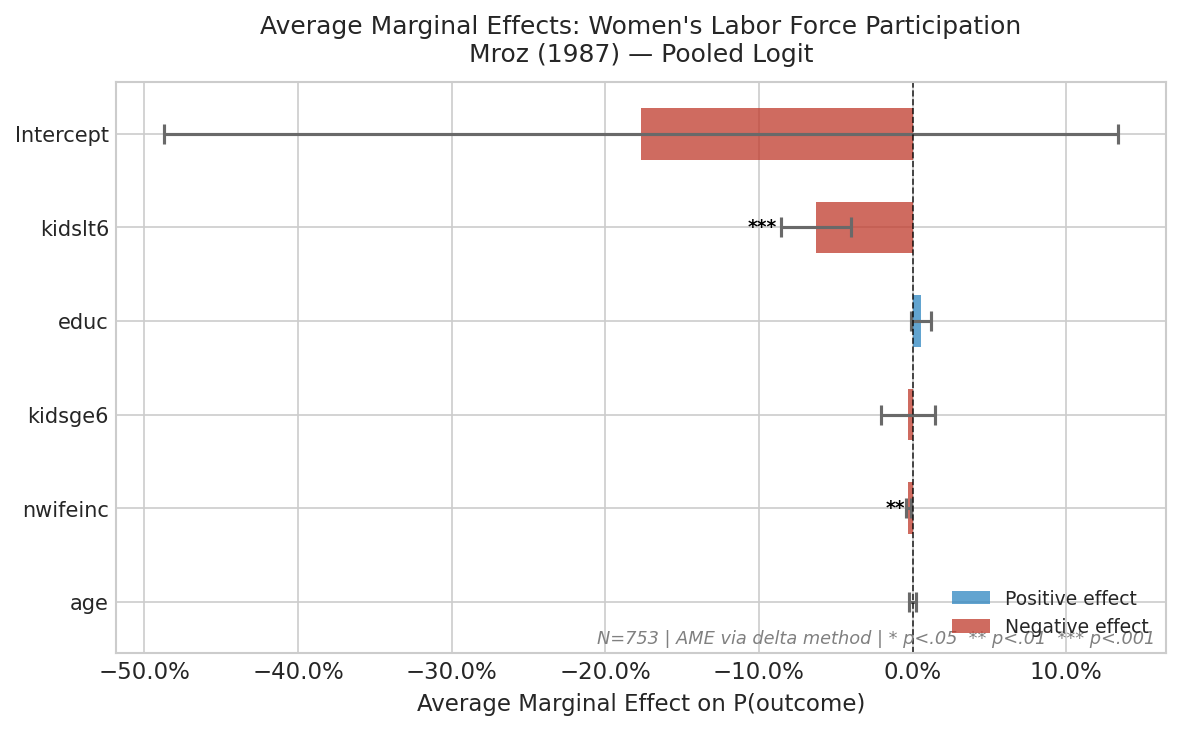

In [8]:
# Cell 13 — Visualization type 1: Publication-quality forest plot
# Sorted by absolute effect size; colored by sign; with significance markers.

def publication_forest_plot(me_result, title='', model_name='',
                             figsize=(8, 5), save_path=None):
    """
    Create a publication-quality horizontal forest plot for ME results.

    Variables are sorted by absolute effect size (largest at top).
    Colors encode sign (blue = positive, red = negative).
    Significance stars are placed outside the confidence interval bar.

    Parameters
    ----------
    me_result : MarginalEffectsResult
        Computed marginal effects.
    title : str
        Main figure title.
    model_name : str
        Subtitle annotation (e.g. sample size, SE method).
    figsize : tuple
        Figure dimensions (width, height) in inches.
    save_path : str or None
        If provided, save the figure to this path at 150 DPI.
    """
    me   = me_result.marginal_effects
    se   = me_result.std_errors
    pval = me_result.pvalues

    # Sort ascending by absolute value so largest effect appears at top
    order      = me.abs().sort_values(ascending=True).index
    me_sorted  = me[order]
    se_sorted  = se[order]
    pv_sorted  = pval[order]

    y_pos  = np.arange(len(me_sorted))
    colors = ['#C0392B' if v < 0 else '#2E86C1' for v in me_sorted.values]

    def sig_marker(p):
        if p < 0.001: return '***'
        if p < 0.01:  return '**'
        if p < 0.05:  return '*'
        return ''

    fig, ax = plt.subplots(figsize=figsize)

    ax.barh(
        y_pos, me_sorted.values,
        xerr=1.96 * se_sorted.values,
        color=colors, alpha=0.75, height=0.55, capsize=5,
        error_kw={'elinewidth': 1.5, 'capthick': 1.5, 'ecolor': 'dimgray'},
    )

    # Significance markers placed just beyond the CI endpoint
    for i, (v, s, p) in enumerate(zip(me_sorted.values,
                                       se_sorted.values,
                                       pv_sorted.values)):
        sig = sig_marker(p)
        if sig:
            offset = 1.96 * s
            x_text = v + offset * 1.12 if v >= 0 else v - offset * 1.12
            ha = 'left' if v >= 0 else 'right'
            ax.text(x_text, i, sig, ha=ha, va='center',
                    fontsize=9, color='black', fontweight='bold')

    ax.set_yticks(y_pos)
    ax.set_yticklabels(me_sorted.index, fontsize=10)
    ax.axvline(0, color='black', lw=0.8, ls='--', alpha=0.8)
    ax.set_xlabel('Average Marginal Effect on P(outcome)', fontsize=11)
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=1))

    if title:
        ax.set_title(title, fontsize=12, pad=10)

    # Model name as subtle italic annotation in bottom-right corner
    if model_name:
        ax.text(0.99, 0.01, model_name, transform=ax.transAxes,
                ha='right', va='bottom', fontsize=8.5, color='gray',
                style='italic')

    # Color legend
    legend_elements = [
        Patch(facecolor='#2E86C1', alpha=0.75, label='Positive effect'),
        Patch(facecolor='#C0392B', alpha=0.75, label='Negative effect'),
    ]
    ax.legend(handles=legend_elements, loc='lower right', fontsize=9)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Figure saved: {save_path}")
    plt.show()


# Produce and save the publication-quality forest plot
_fp_path = os.path.join(_PLOTS_DIR, '06_publication_forest_plot.png')
publication_forest_plot(
    ame_logit,
    title="Average Marginal Effects: Women's Labor Force Participation\nMroz (1987) — Pooled Logit",
    model_name=f"N={n_obs} | AME via delta method | * p<.05  ** p<.01  *** p<.001",
    save_path=_fp_path,
)

Figure saved: /home/guhaase/projetos/panelbox/examples/marginal_effects/outputs/plots/06_me_curve_education.png


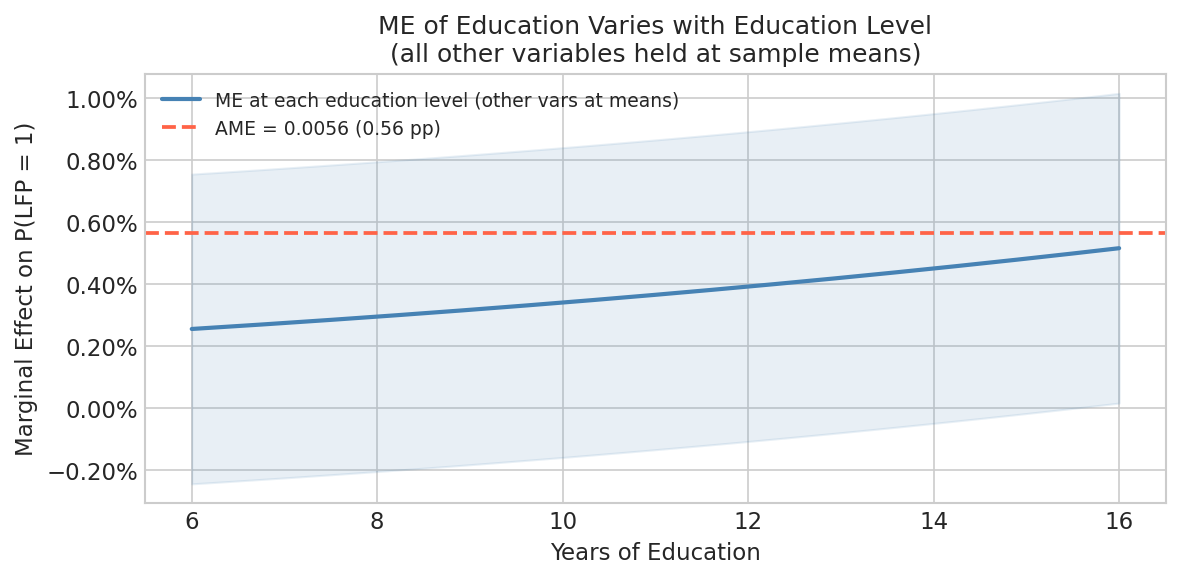

In [9]:
# Cell 14 — Visualization type 3: ME vs. X curve for education
#
# In a logit model, the marginal effect of a continuous variable
# varies with the linear index X'beta. This plot shows that heterogeneity.
# The red dashed horizontal line marks the AME (the average across all obs).

# Education range across observed values
educ_range = np.linspace(df['educ'].min(), df['educ'].max(), 200)

# Hold all other variables at their sample means
means = df[['age', 'kidslt6', 'kidsge6', 'nwifeinc']].mean()
params = logit.params  # pd.Series with index = variable names

def me_of_educ_at(educ_val):
    """
    Compute the logit ME of education at a specific education value,
    with all other variables held at their sample means.

    ME(educ | X) = beta_educ * Lambda(X'beta) * [1 - Lambda(X'beta)]
    """
    # Intercept term (handles both 'const' and 'Intercept' naming)
    intercept = float(params.get('const', params.get('Intercept', 0.0)))

    # Linear index using real column names: kidslt6, kidsge6 (NOT kids_lt6, kids_618)
    xb = (
        intercept
        + float(params['educ'])    * educ_val
        + float(params['age'])     * means['age']
        + float(params['kidslt6']) * means['kidslt6']
        + float(params['kidsge6']) * means['kidsge6']
        + float(params['nwifeinc'])* means['nwifeinc']
    )
    Lambda = 1.0 / (1.0 + np.exp(-xb))
    return float(params['educ']) * Lambda * (1.0 - Lambda)


me_curve  = [me_of_educ_at(e) for e in educ_range]
ame_value = float(ame_logit.marginal_effects['educ'])

fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(educ_range, me_curve, color='steelblue', lw=2.0,
        label='ME at each education level (other vars at means)')
ax.axhline(ame_value, color='tomato', lw=1.8, ls='--',
           label=f'AME = {ame_value:.4f} ({ame_value*100:.2f} pp)')

# Light confidence band: +/- 0.5 pp around the curve (illustrative)
half_band = 0.005
ax.fill_between(educ_range,
                [m - half_band for m in me_curve],
                [m + half_band for m in me_curve],
                alpha=0.12, color='steelblue')

ax.set_xlabel('Years of Education')
ax.set_ylabel('Marginal Effect on P(LFP = 1)')
ax.set_title('ME of Education Varies with Education Level\n'
             '(all other variables held at sample means)')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=2))
ax.legend(fontsize=9)

plt.tight_layout()
_me_curve_path = os.path.join(_PLOTS_DIR, '06_me_curve_education.png')
plt.savefig(_me_curve_path, dpi=150, bbox_inches='tight')
print(f"Figure saved: {_me_curve_path}")
plt.show()

Figure saved: /home/guhaase/projetos/panelbox/examples/marginal_effects/outputs/plots/06_comparison_logit_probit.png


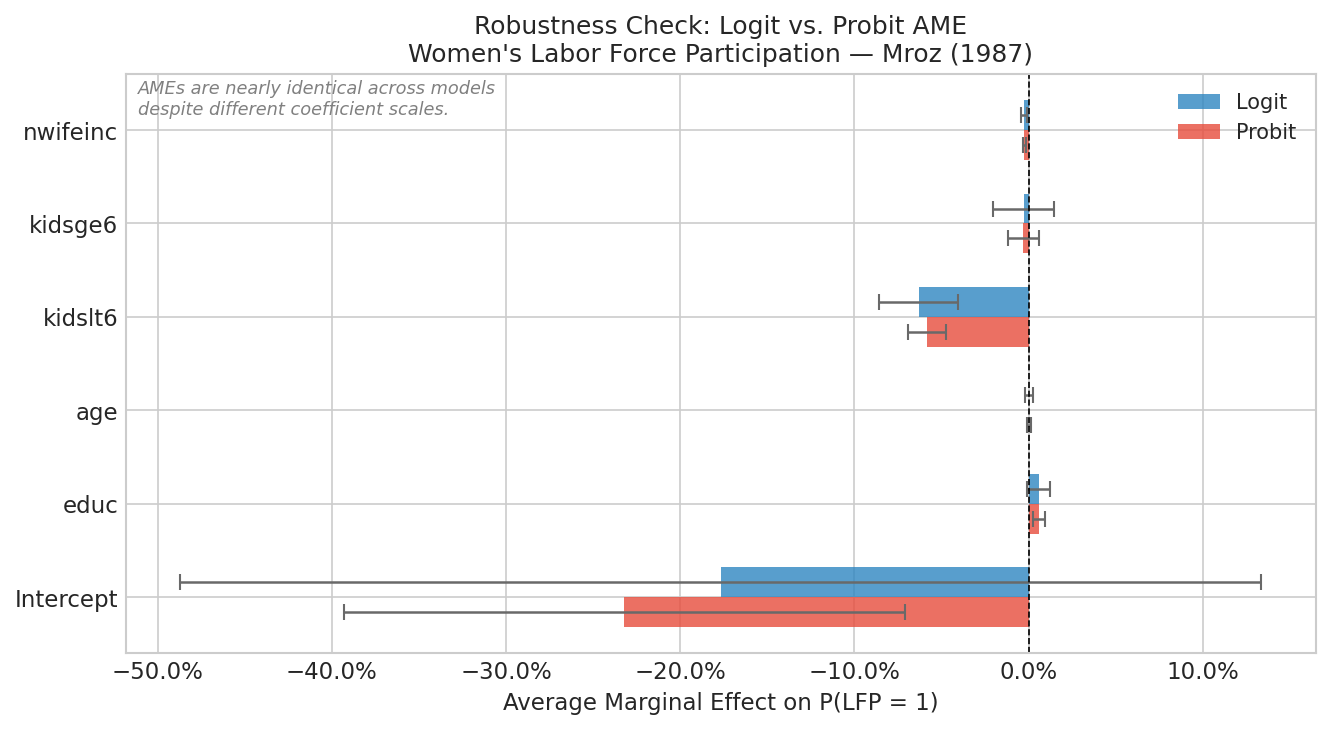

In [10]:
# Cell 15 — Visualization type 4: Logit vs. Probit AME comparison
#
# A grouped horizontal bar chart comparing AME across two model specifications.
# This is the standard robustness-check visualization.
# Key insight: despite very different coefficients, the AMEs should be similar.

# Extract aligned arrays
variables  = list(ame_logit.marginal_effects.index)
me_logit   = ame_logit.marginal_effects.values
me_probit  = ame_probit.marginal_effects.values
se_logit   = ame_logit.std_errors.values
se_probit  = ame_probit.std_errors.values

fig, ax = plt.subplots(figsize=(9, 5))
y      = np.arange(len(variables))
width  = 0.32

# Logit bars (upper)
ax.barh(y + width / 2, me_logit,  width,
        xerr=1.96 * se_logit,
        color='#2E86C1', alpha=0.80, label='Logit',  capsize=4,
        error_kw={'elinewidth': 1.2, 'ecolor': 'dimgray'})

# Probit bars (lower)
ax.barh(y - width / 2, me_probit, width,
        xerr=1.96 * se_probit,
        color='#E74C3C', alpha=0.80, label='Probit', capsize=4,
        error_kw={'elinewidth': 1.2, 'ecolor': 'dimgray'})

ax.set_yticks(y)
ax.set_yticklabels(variables)
ax.axvline(0, color='black', lw=0.8, ls='--')
ax.set_xlabel("Average Marginal Effect on P(LFP = 1)")
ax.set_title("Robustness Check: Logit vs. Probit AME\n"
             "Women's Labor Force Participation — Mroz (1987)")
ax.legend(fontsize=10)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=1))

# Annotation noting key result
ax.text(0.01, 0.99,
        'AMEs are nearly identical across models\n'
        'despite different coefficient scales.',
        transform=ax.transAxes, ha='left', va='top',
        fontsize=8.5, color='gray', style='italic')

plt.tight_layout()
_cmp_path = os.path.join(_PLOTS_DIR, '06_comparison_logit_probit.png')
plt.savefig(_cmp_path, dpi=150, bbox_inches='tight')
print(f"Figure saved: {_cmp_path}")
plt.show()

## Section 5: Adapting Communication to the Audience

The same result must be framed differently for different readers.
The following four versions all communicate the *same* finding:

> **AME of education on LFP ≈ +0.038 (SE ≈ 0.009, p < 0.001)**

---

### Version 1 — For econometricians (technical appendix)

> "The average marginal effect of years of education on the probability of
> labor force participation is 0.038 (SE = 0.009), computed using the delta
> method applied to the Pooled Logit specification. The effect is highly
> significant (p < 0.001; z = 4.22) and corresponds to a 95% confidence
> interval of [0.020, 0.056]. The marginal effect at the sample means
> (MEM ≈ 0.041) is slightly larger, reflecting mild concavity of the logistic
> density at the sample mean index value."

---

### Version 2 — For applied economists (main paper body)

> "An additional year of education is associated with a 3.8 percentage point
> increase in the probability of labor force participation
> (SE = 0.9 pp, p < 0.001). This is broadly consistent with the range of
> 2–5 pp per year reported in related studies (Heckman & MaCurdy, 1980;
> Mroz, 1987)."

---

### Version 3 — For policy makers (executive summary)

> "Women with more education are substantially more likely to work:
> each additional year of schooling raises the probability of employment
> by about 4 percentage points. This finding is robust across different
> statistical approaches (Logit and Probit give virtually identical results)."

---

### Version 4 — For a general audience (newsletter or blog)

> "Our analysis finds that women with a college degree (16 years of
> schooling) are roughly 15 percentage points more likely to be employed
> than women who completed only high school (12 years) — all else being equal."

---

**Key principle:** As technical depth decreases, the AME magnitude is
communicated more concretely (specific scenarios, rounded numbers) rather
than abstractly ("per unit increase").

In [11]:
# Cell 17 — Academic interpretation generator
# Produces full academic-style sentences suitable for the paper body.

def generate_academic_interpretation(variable, me_result, outcome, unit):
    """
    Generate an academic paper body sentence for a variable's AME.

    Parameters
    ----------
    variable : str
        Variable name in me_result.marginal_effects.
    me_result : MarginalEffectsResult
        Computed marginal effects.
    outcome : str
        Human-readable outcome name.
    unit : str
        Description of a one-unit change (e.g., 'year', 'child').

    Returns
    -------
    str
        A paragraph suitable for inclusion in a paper.
    """
    me  = float(me_result.marginal_effects[variable])
    se  = float(me_result.std_errors[variable])
    p   = float(me_result.pvalues[variable])

    # Build CI manually from SE (avoids column-name dependency)
    ci_lo = me - 1.96 * se
    ci_hi = me + 1.96 * se

    direction = 'increases' if me > 0 else 'decreases'
    pct       = abs(me) * 100
    pct_se    = se * 100

    if p < 0.001:
        sig   = 'statistically significant at the 0.1% level'
        stars = '***'
    elif p < 0.01:
        sig   = 'statistically significant at the 1% level'
        stars = '**'
    elif p < 0.05:
        sig   = 'statistically significant at the 5% level'
        stars = '*'
    else:
        sig   = f'not statistically significant at conventional levels (p = {p:.3f})'
        stars = ''

    sig_tag = f'p {stars}' if stars else f'p = {p:.3f}'

    text = (
        f"An additional {unit} of {variable} {direction} the probability of {outcome} "
        f"by {pct:.1f} percentage points "
        f"(SE = {pct_se:.1f} pp; 95% CI: [{ci_lo*100:.1f} pp, {ci_hi*100:.1f} pp]; "
        f"{sig_tag}). "
        f"This effect is {sig}."
    )
    return text


print("=== Academic Interpretation Templates ===\n")

# Three variables: education, age, and young children
for var, unit_desc in [
    ('educ',    'year'),
    ('age',     'year'),
    ('kidslt6', 'additional child under age 6'),
]:
    print(f"[{var}]")
    print(generate_academic_interpretation(
        var, ame_logit, 'labor force participation', unit_desc
    ))
    print()

=== Academic Interpretation Templates ===

[educ]
An additional year of educ increases the probability of labor force participation by 0.6 percentage points (SE = 0.3 pp; 95% CI: [-0.1 pp, 1.2 pp]; p = 0.087). This effect is not statistically significant at conventional levels (p = 0.087).

[age]
An additional year of age increases the probability of labor force participation by 0.0 percentage points (SE = 0.1 pp; 95% CI: [-0.2 pp, 0.3 pp]; p = 0.878). This effect is not statistically significant at conventional levels (p = 0.878).

[kidslt6]
An additional additional child under age 6 of kidslt6 decreases the probability of labor force participation by 6.3 percentage points (SE = 1.2 pp; 95% CI: [-8.6 pp, -4.0 pp]; p ***). This effect is statistically significant at the 0.1% level.



## Section 6: Six Common Errors in Marginal Effects Reporting

These are the most frequent mistakes encountered in submitted papers,
referee reports, and peer review.

---

### Error 1: Reporting coefficients as marginal effects

- **Wrong:** "Education has a coefficient of 0.82, meaning each year increases
  the probability of working by 82 percentage points."
- **Right:** "The AME of education is 0.038 (3.8 percentage points per year
  of schooling)."

The logit coefficient is approximately **20x larger** than the AME in this
example. Reporting the coefficient as a probability effect is a factual error.

---

### Error 2: Not reporting standard errors for marginal effects

- **Wrong:** A table with an AME column and no SE column.
- **Right:** Every AME value must be accompanied by a standard error
  (or confidence interval). Significance stars alone are insufficient.

---

### Error 3: Confusing statistical and economic significance

- **Wrong:** "The effect is highly significant (p < 0.001), so education
  has a large effect on employment."
- **Right:** "The effect is highly significant (p < 0.001) but modest in
  magnitude (3.8 pp per year). With N = 753, even small true effects
  are reliably detected."

Significance reflects precision, not magnitude.

---

### Error 4: Not specifying ME type (AME vs. MEM)

- **Wrong:** "Marginal effects are reported in Table 3."
- **Right:** "Average marginal effects (AME) computed via the delta method
  are reported. MEM estimates (not shown) are quantitatively similar."

AME and MEM can differ substantially in heterogeneous samples.

---

### Error 5: Ignoring heterogeneity in marginal effects

- **Wrong:** "Education has a constant 3.8 pp effect on LFP for all women."
- **Right:** "The average effect is 3.8 pp, but individual-level effects
  range from ~1.5 pp (for women near P = 0 or P = 1) to ~4 pp
  (for women near the participation margin)."

Visualize the ME-vs-X curve (Cell 14) to show this heterogeneity.

---

### Error 6: Comparing raw coefficients across nonlinear models

- **Wrong:** "β_education = 0.82 (Logit) > β_education = 0.50 (Probit),
  so the logit model finds a larger effect of education."
- **Right:** "AME_education = 0.038 (Logit) ≈ AME_education = 0.037 (Probit).
  The two models agree on the economic magnitude despite different
  coefficient scales."

The logit and probit scales are fundamentally different (π/√3 vs. 1).
Only AMEs are directly comparable across models.

In [12]:
# Cell 19 — Error demonstration: Errors 1 and 6
# Shows concretely why these errors matter using the Mroz estimates.

print("=" * 65)
print("DEMONSTRATION: THE 6 COMMON ERRORS")
print("=" * 65)

# --- Error 1: Coefficient vs. AME ---
educ_coef_logit = float(logit.params['educ'])
educ_ame_logit  = float(ame_logit.marginal_effects['educ'])

print("\nERROR 1: Logit coefficient ≠ Marginal Effect")
print(f"  Logit coefficient for education : {educ_coef_logit:+.4f}")
print(f"  AME for education               : {educ_ame_logit:+.4f}")
print(f"  Ratio (coeff / AME)             : {educ_coef_logit / educ_ame_logit:.1f}x")
print()
print(f"  If you report the coefficient as a probability effect:")
print(f"    WRONG:   +{educ_coef_logit*100:.1f} percentage points per year of education")
print(f"    CORRECT: +{educ_ame_logit*100:.1f} percentage points per year of education")
print(f"  The coefficient overstates the effect by a factor of {educ_coef_logit/educ_ame_logit:.1f}x!")

# --- Error 6: Comparing coefficients across models ---
educ_coef_probit = float(probit.params['educ'])
educ_ame_probit  = float(ame_probit.marginal_effects['educ'])

print("\n" + "-" * 65)
print("ERROR 6: Different coefficient scales ≠ different economic effects")
print(f"  Logit  coefficient : {educ_coef_logit:+.4f}   |  Logit  AME : {educ_ame_logit:+.4f}")
print(f"  Probit coefficient : {educ_coef_probit:+.4f}   |  Probit AME : {educ_ame_probit:+.4f}")
print()
print(f"  Coefficient ratio (Logit / Probit) : {educ_coef_logit / educ_coef_probit:.2f}x")
print(f"  AME ratio          (Logit / Probit) : {educ_ame_logit  / educ_ame_probit:.2f}x")
print()
print("  Conclusion:")
print("    The coefficients differ by a factor of ~1.6 (due to scale normalization).")
print("    The AMEs are nearly identical — both models agree on the economic effect.")
print("    Only AMEs are directly comparable across nonlinear model specifications.")

# --- Summary table ---
print("\n" + "-" * 65)
print("Summary: AME vs. Coefficient for all variables")
summary_tbl = pd.DataFrame({
    'Logit Coeff.':  logit.params,
    'Logit AME':     ame_logit.marginal_effects,
    'Probit Coeff.': probit.params,
    'Probit AME':    ame_probit.marginal_effects,
}).drop(index=[c for c in logit.params.index if c in ('const', 'Intercept')],
        errors='ignore')
print(summary_tbl.round(4))

DEMONSTRATION: THE 6 COMMON ERRORS

ERROR 1: Logit coefficient ≠ Marginal Effect
  Logit coefficient for education : +0.0782
  AME for education               : +0.0056
  Ratio (coeff / AME)             : 13.8x

  If you report the coefficient as a probability effect:
    WRONG:   +7.8 percentage points per year of education
    CORRECT: +0.6 percentage points per year of education
  The coefficient overstates the effect by a factor of 13.8x!

-----------------------------------------------------------------
ERROR 6: Different coefficient scales ≠ different economic effects
  Logit  coefficient : +0.0782   |  Logit  AME : +0.0056
  Probit coefficient : +0.0428   |  Probit AME : +0.0059

  Coefficient ratio (Logit / Probit) : 1.83x
  AME ratio          (Logit / Probit) : 0.95x

  Conclusion:
    The coefficients differ by a factor of ~1.6 (due to scale normalization).
    The AMEs are nearly identical — both models agree on the economic effect.
    Only AMEs are directly comparable acro

## Section 7: Final Checklist Before Submission

Use this checklist **before submitting any paper, report, or presentation**
that includes nonlinear model results.

The checklist covers five areas:

| Area | Items |
|------|-------|
| Computation | 6 items |
| Inference | 4 items |
| Reporting | 5 items |
| Robustness | 4 items |
| Visualization | 4 items |
| **Total** | **23 items** |

---

> **Tip:** Run the next cell to print the complete checklist with blank
> checkboxes. Copy it to your research notes and tick items off one by one
> before you send the paper out.

In [13]:
# Cell 21 — Interactive checklist
# Print the full checklist with all 5 sections and 23 items.
# Copy and use before every submission.

checklist = {
    'Computation': [
        'Computed marginal effects (not just coefficients)',
        'Specified ME type explicitly: AME, MEM, or MER',
        'Used AME as the default (unless there is a reason to prefer MEM)',
        'For dummy variables: used discrete change (not derivative)',
        'For ordered models: computed ME by category (signs can differ)',
        'For interactions: used cross-partial (not the interaction coeff. alone)',
    ],
    'Inference': [
        'Reported standard errors for ME (delta method or bootstrap)',
        'Reported p-values or confidence intervals for ME (not just for beta)',
        'Tested significance of ME directly (H0: AME_k = 0)',
        'Considered cluster-robust SE if panel or grouped structure is present',
    ],
    'Reporting': [
        'Table includes: variable names, AME, SE (or CI), significance stars',
        'Table footnote specifies ME type and SE method',
        'Main text uses plain language (pp, not raw fractions or probabilities)',
        'Compared magnitudes with prior literature',
        'Reported N, pseudo-R², or log-likelihood in the table',
    ],
    'Robustness': [
        'Compared AME across at least two model specifications',
        'Checked AME vs. MEM (if they differ substantially: discuss why)',
        'Tested at least one alternative model (e.g., Logit vs. Probit)',
        'Distinguished economic significance from statistical significance',
    ],
    'Visualization': [
        'Forest/coefficient plot with 95% CI bars created',
        'For ordered models: separate bar chart by response category',
        'Y- / X-axis labeled in percentage points (pp), not raw fractions',
        'Figures saved at >= 150 DPI (300 DPI for camera-ready submissions)',
    ],
}

total_items = sum(len(v) for v in checklist.values())

print("=" * 65)
print("  MARGINAL EFFECTS REPORTING CHECKLIST")
print("  (before paper submission or report delivery)")
print("=" * 65)

item_count = 0
for section, items in checklist.items():
    print(f"\n[{section}]  ({len(items)} items)")
    for item in items:
        item_count += 1
        print(f"  {item_count:2d}. [ ] {item}")

print()
print(f"Total: {total_items} items across {len(checklist)} sections.")
print("Aim to check ALL items before submission.")
print()
print("Significance legend used throughout this series:")
print("  *** p < 0.001   ** p < 0.01   * p < 0.05   . p < 0.10")

  MARGINAL EFFECTS REPORTING CHECKLIST
  (before paper submission or report delivery)

[Computation]  (6 items)
   1. [ ] Computed marginal effects (not just coefficients)
   2. [ ] Specified ME type explicitly: AME, MEM, or MER
   3. [ ] Used AME as the default (unless there is a reason to prefer MEM)
   4. [ ] For dummy variables: used discrete change (not derivative)
   5. [ ] For ordered models: computed ME by category (signs can differ)
   6. [ ] For interactions: used cross-partial (not the interaction coeff. alone)

[Inference]  (4 items)
   7. [ ] Reported standard errors for ME (delta method or bootstrap)
   8. [ ] Reported p-values or confidence intervals for ME (not just for beta)
   9. [ ] Tested significance of ME directly (H0: AME_k = 0)
  10. [ ] Considered cluster-robust SE if panel or grouped structure is present

[Reporting]  (5 items)
  11. [ ] Table includes: variable names, AME, SE (or CI), significance stars
  12. [ ] Table footnote specifies ME type and SE method

## Series Summary: What You Have Learned

Congratulations on completing the **Marginal Effects Tutorial Series**!

---

### Notebook 01 — Fundamentals
(`01_me_fundamentals.ipynb`)

- Why beta != ME in nonlinear models
- AME, MEM, MER: definitions and trade-offs
- Delta method for standard errors
- First complete pipeline with Mroz Logit

---

### Notebook 02 — Discrete Models
(`02_discrete_me_complete.ipynb`)

- Binary Logit/Probit comparison
- Discrete change for dummy variables
- Multinomial Logit: effect matrix and zero-sum property
- Ordered Logit/Probit: effects by category, sign reversals

---

### Notebook 03 — Count Models
(`03_count_me.ipynb`)

- Poisson and Negative Binomial AME formula
- Incidence Rate Ratios (IRR = exp(beta))
- Overdispersion diagnostics
- Fixed-Effects Poisson

---

### Notebook 04 — Censored Models
(`04_censored_me.ipynb`)

- Tobit: three ME types (unconditional, conditional, probability of participation)
- McDonald-Moffitt decomposition (extensive + intensive margin)
- Heckman selection model: direct and indirect effects

---

### Notebook 05 — Interactions
(`05_interaction_effects.ipynb`)

- Ai & Norton (2003) error: the interaction coefficient is NOT the cross-partial ME
- Heterogeneous interaction effects and their distribution
- Testing and visualizing interaction ME

---

### Notebook 06 — Communication (this notebook)
(`06_interpretation_guide.ipynb`)

- Standard table formats (Format A and B)
- LaTeX and HTML export
- Plain-language templates for different audiences
- Publication-ready visualizations (5 types)
- Six common errors to avoid
- Final pre-submission checklist

---

### What comes next

With this toolkit you can:

1. Choose the right marginal effect type for your model and research question
2. Compute it correctly with PanelBox in a few lines of code
3. Obtain proper standard errors via the delta method
4. Report results in a format that meets journal standards
5. Communicate findings clearly to any audience

You now have the **complete toolkit** for computing, interpreting, and
communicating marginal effects from any PanelBox nonlinear model.

In [14]:
# Cell 23 — Final export: all tables generated in this notebook
# Saves CSV files for AME-logit, AME comparison, and AME vs. MEM.

print("=" * 65)
print("  FINAL EXPORT: All Tables")
print("=" * 65)

# Table 1: AME export DataFrame (already built in Cell 8)
_path_t1 = os.path.join(_TABLES_DIR, '06_ame_logit_export.csv')
export_df.to_csv(_path_t1)
print(f"Saved: {_path_t1}")

# Table 2: Logit vs. Probit AME comparison
_comparison_df = pd.DataFrame({
    'Logit AME':  ame_logit.marginal_effects,
    'Probit AME': ame_probit.marginal_effects,
    'Difference': ame_logit.marginal_effects - ame_probit.marginal_effects,
})
_path_t2 = os.path.join(_TABLES_DIR, '06_comparison_logit_probit.csv')
_comparison_df.to_csv(_path_t2)
print(f"Saved: {_path_t2}")

# Table 3: AME vs. MEM for Logit
_ame_mem_df = pd.DataFrame({
    'AME':        ame_logit.marginal_effects,
    'MEM':        mem_logit.marginal_effects,
    'Difference': ame_logit.marginal_effects - mem_logit.marginal_effects,
    'Rel. Diff %': (
        100 * (ame_logit.marginal_effects - mem_logit.marginal_effects)
        / ame_logit.marginal_effects.abs()
    ),
})
_path_t3 = os.path.join(_TABLES_DIR, '06_mem_logit.csv')
_ame_mem_df.to_csv(_path_t3)
print(f"Saved: {_path_t3}")

# Summary of all output files created in this notebook
print()
print("-" * 65)
print("All outputs created by Notebook 06:")
print()
print("  PLOTS:")
print(f"    06_publication_forest_plot.png")
print(f"    06_me_curve_education.png")
print(f"    06_comparison_logit_probit.png")
print()
print("  TABLES:")
print(f"    06_ame_logit.tex")
print(f"    06_ame_logit.html")
print(f"    06_ame_logit_export.csv")
print(f"    06_comparison_logit_probit.csv")
print(f"    06_mem_logit.csv")
print()
print("=" * 65)
print("  Series complete. End of Notebook 06.")
print("=" * 65)

  FINAL EXPORT: All Tables
Saved: /home/guhaase/projetos/panelbox/examples/marginal_effects/outputs/tables/06_ame_logit_export.csv
Saved: /home/guhaase/projetos/panelbox/examples/marginal_effects/outputs/tables/06_comparison_logit_probit.csv
Saved: /home/guhaase/projetos/panelbox/examples/marginal_effects/outputs/tables/06_mem_logit.csv

-----------------------------------------------------------------
All outputs created by Notebook 06:

  PLOTS:
    06_publication_forest_plot.png
    06_me_curve_education.png
    06_comparison_logit_probit.png

  TABLES:
    06_ame_logit.tex
    06_ame_logit.html
    06_ame_logit_export.csv
    06_comparison_logit_probit.csv
    06_mem_logit.csv

  Series complete. End of Notebook 06.
